In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Your Sample Data
# -----------------------------------------------------------------------------

green_data = [
    (214,217,162), (202,207,149), (195,201,155), (216,222,194), (195,199,140),
    (233,237,210), (203,207,148), (192,196,120), (200,204,130), (198,204,134),
    (208,213,159), (221,225,175), (236,240,203), (212,218,180), (203,209,173),
    (232,237,197), (198,202,151), (241,244,215), (127,135,76),  (130,134,73),
    (127,126,70),  (211,216,162), (216,219,166), (210,213,156), (207,213,151),
    (220,224,173), (210,218,169), (211,219,172), (205,214,167), (198,209,151),
    (174,189,146), (206,212,174), (208,215,173), (208,215,181), (208,214,168),
    (127,137,76),  (185,190,132), (154,143,87),  (210,205,149), (217,215,154),
    (218,221,168), (240,236,201), (245,250,218), (218,223,159), (218,221,164),
    (212,218,146), (212,219,139), (216,223,146), (206,209,138), (195,193,118),
    (211,209,158), (223,221,173), (212,211,167)
]

orange_data = [
    (136,90,77),  (95,47,27),   (135,99,67),  (145,99,65),   (128,88,62),
    (141,100,56), (172,146,89), (227,206,163),(225,198,145),(231,207,159),
    (240,220,193),(214,193,148),(156,109,53), (163,121,63), (150,99,46),
    (164,132,93), (179,142,90), (150,105,50), (161,118,67), (193,169,125),
    (206,192,165),(191,165,106),(189,145,98), (213,169,124),(209,177,136),
    (211,176,134),(209,179,143),(207,181,148),(200,176,142),(192,163,131),
    (160,115,58), (167,133,96), (167,127,68), (185,146,105),(193,172,141),
    (141,99,74),  (183,148,116),(173,136,107),(185,154,123),(187,165,141)
]


def classify_pixel(r, g, b, T1, T2):
    """
    Classify one pixel (r,g,b) as 'orange' if:
      (r - g >= T1) AND (r - b >= T2),
    otherwise 'green'.
    """
    if (r - g >= T1) and (r - b >= T2):
        return "orange"
    else:
        return "green"

# =============================================================================
# 3) Compute Accuracy for a Given (T1, T2)
# =============================================================================

def compute_accuracy(green_data, orange_data, T1, T2):
    correct = 0
    total = len(green_data) + len(orange_data)

    # Green samples => should be classified "green"
    for (r,g,b) in green_data:
        pred = classify_pixel(r,g,b, T1, T2)
        if pred == "green":
            correct += 1

    # Orange samples => should be classified "orange"
    for (r,g,b) in orange_data:
        pred = classify_pixel(r,g,b, T1, T2)
        if pred == "orange":
            correct += 1

    return correct / float(total) if total > 0 else 0

# =============================================================================
# 4) Grid-Search to Find Best (T1, T2)
# =============================================================================

def find_best_thresholds(green_data, orange_data):
    best_acc = 0.0
    best_T1, best_T2 = 0, 0

    for T1 in range(-50, 51):
        for T2 in range(-50, 51):
            acc = compute_accuracy(green_data, orange_data, T1, T2)
            if acc > best_acc:
                best_acc = acc
                best_T1, best_T2 = T1, T2

    return best_T1, best_T2, best_acc

In [5]:
def classify_pistil_image_with_mask(pistil_rgb, pistil_mask, T1, T2):
    """
    Classify each pixel in 'pistil_rgb' (RGB) as orange or green using (T1, T2),
    but only for pixels where 'pistil_mask' > 0 (non-black).
    We ignore background pixels (mask=0).

    Returns:
      classified_img: color-coded image (orange or green in RGB).
      orange_ratio, green_ratio: fraction of masked pixels that are orange or green.
                                They sum to 1 if there's at least one valid pixel.
    """
    h, w, _ = pistil_rgb.shape
    classified_img = np.zeros_like(pistil_rgb, dtype=np.uint8)

    orange_count = 0
    green_count = 0
    total_masked = 0

    # We'll color 'orange' as (255,165,0) in RGB, 'green' as (0,255,0)
    for y in range(h):
        for x in range(w):
            # Check if this pixel is part of the pistil
            if pistil_mask[y, x] > 0:
                total_masked += 1
                r, g, b = pistil_rgb[y, x]
                pred = classify_pixel(r, g, b, T1, T2)
                if pred == "orange":
                    orange_count += 1
                    classified_img[y, x] = (255, 165, 0)  # orange
                else:
                    green_count += 1
                    classified_img[y, x] = (0, 255, 0)    # green
            else:
                # Keep background black (0,0,0)
                classified_img[y, x] = (0, 0, 0)

    if total_masked == 0:
        return classified_img, 0.0, 0.0

    orange_ratio = orange_count / float(total_masked)
    green_ratio  = green_count  / float(total_masked)
    return classified_img, orange_ratio, green_ratio

Best thresholds found:
  T1 = 12, T2 = -50, Accuracy on sample data = 100.00%


/tmp/ipykernel_4186134/516835368.py:41: RuntimeWarning: overflow encountered in scalar subtract
  if (r - g >= T1) and (r - b >= T2):


Orange Ratio (masked): 99.11%
Green Ratio (masked):  0.89%
Sum:                   100.00%


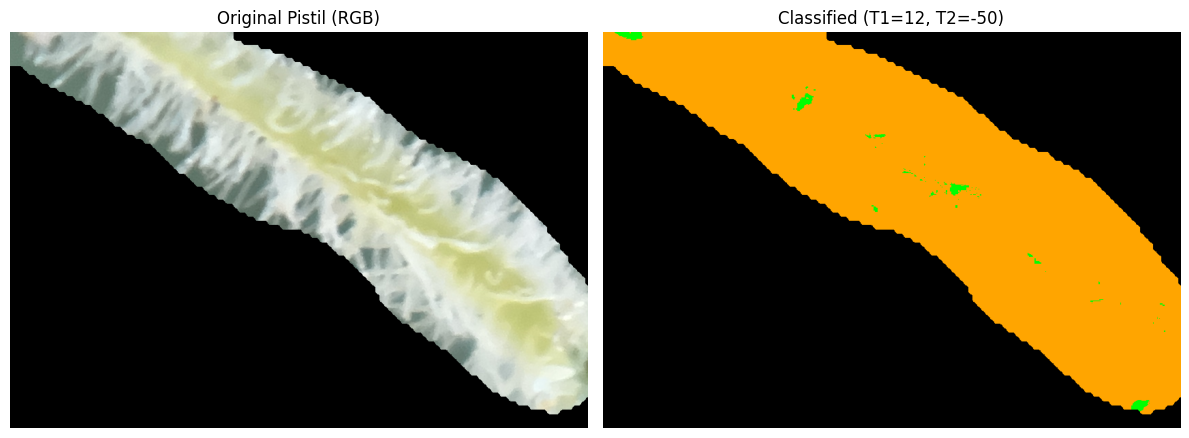

In [10]:
# A) Find best thresholds for your sample data
T1, T2, best_acc = find_best_thresholds(green_data, orange_data)
print(f"Best thresholds found:")
print(f"  T1 = {T1}, T2 = {T2}, Accuracy on sample data = {best_acc*100:.2f}%")

pistil_rgba = cv2.imread("/home/etaylor/code_projects/thesis/segments/etaylor_stigmas_color_dataset/v0.2/IMG_0526_pistil_1.png", cv2.IMREAD_UNCHANGED)

# Separate channels
rgb = pistil_rgba[:, :, :3]      # (H, W, 3)
alpha = pistil_rgba[:, :, 3]     # (H, W) alpha mask

# Convert alpha into a binary mask (e.g. > 0 => inside pistil)
pistil_mask = np.where(alpha > 0, 255, 0).astype(np.uint8)

if pistil_rgba is None or pistil_mask is None:
    print("Either the pistil image or the mask not found. Please update paths.")
else:
    # Convert the image to RGB
    pistil_rgb = cv2.cvtColor(pistil_rgba, cv2.COLOR_BGR2RGB)

    # Classify using the best thresholds
    classified_img, orange_ratio, green_ratio = classify_pistil_image_with_mask(
        pistil_rgb, pistil_mask, T1, T2
    )

    print(f"Orange Ratio (masked): {orange_ratio*100:.2f}%")
    print(f"Green Ratio (masked):  {green_ratio*100:.2f}%")
    print(f"Sum:                   {(orange_ratio+green_ratio)*100:.2f}%")

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(pistil_rgb)
    axes[0].set_title("Original Pistil (RGB)")
    axes[0].axis("off")

    axes[1].imshow(classified_img)
    axes[1].set_title(f"Classified (T1={T1}, T2={T2})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()